<a href="https://colab.research.google.com/github/neelamtm/7316/blob/main/geobia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://github.com/chikaj/wekeo_competition_2022/blob/main/img/banner2.png?raw=1' align='left' width='75%'/>

**Authors:** Nate Currit <br>
**Copyright:** 2022 Nate Currit <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>Geographic Object-Based Image Analysis (GEOBIA)</h3></div>

# INTRODUCTION

## Learning outcomes

At the end of this notebook you will know:
* What GEOBIA is and what its advantages are over other image classification methods
* The steps of GEOBIA
* How to perform GEOBIA using open source tools


## Outline

Geographic object-based image analysis is a response to pixel-based image analysis. The literature on GEOBIA is extensive, but the following peer-reviewed articles will get you started.The first two articles are conceptual and cover periods when GEOBIA was gaining broad acceptance and as it was maturing. The third article is an application that directly compares GEOBIA results to pixel-based results.

* Blaschke, T., Hay, G.J., Kelly, M., Land, S., Hofmann, P., Addink, E., Queiroz Feitosa, R., van der Meer, F., van der Werff, H., van Coille and F, Tiede, D. (2014) <a href="https://www.sciencedirect.com/science/article/pii/S0924271613002220" target="_blank">Geographic Object-Based Image Analysis – Towards a new paradigm</a>. ISPRS Journal of Photogrammetry and Remote Sensing. Vol. 87: 180-191.
* Chen, G., Weng, Q., Hay, G.J. and He, Y. (2018) <a href="https://www.tandfonline.com/doi/pdf/10.1080/15481603.2018.1426092" target="_blank">Geographic object-based image analysis (GEOBIA): emerging trends and future opportunities</a>. GIScience and Remote Sensing. Vol, 55, No. 2: 159-182.
* Facco, D.S., Guasselli, L.A., Chimelo Ruiz, L.F., Delapasse Simioni, J.P. and Dick, D.G. (2021) <a href="https://www.tandfonline.com/doi/abs/10.1080/10106049.2021.1899302?journalCode=tgei20" target="_blank">Comparison of PBIA and GEOBIA classification methods in classifying turbidity in reservoir</a>. GeoCarto International. Vol. 37, Iss. 16: 4762-4783.

The rest of this notebook will be divided into the following content parts.

<div class="alert alert-info" role="alert">

### <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Background](#background)
 2. [Segmentation](#segmentation)
 3. [Attribution](#attribution)
 4. [Classification](#classification)
 5. [Challenge](#challenge)


<hr>

<div class="alert alert-info" role="alert">

### <a id='background'></a>1. Background
A brief introduction to GEOBIA.
    
[Back to top](#TOC_TOP)

</div>

### High resolution vs Low resolution imagery
Orbital and sub-orbital imagery has 4 unique kinds of resolution: spatial, spectral, radiometric and temporal. Spatial resolution is the one-sided distance of a ground resolution cell, or pixel, measured using a linear unit (i.e., meters). High spatial resolution imagery has smaller pixels than coarse spatial resolution imagery. This section presents new ways to consider spatial resolution in the context of GEOBIA.

The previous definitions of spatial resolution focus on inherent characteristics of the imagery itself, but pixel size also has an important relationship with the objects of interest on the ground. **H-resolution** and **L-resolution** refer to situations when image pixels are smaller or larger, respectively, than objects of interest on the ground. That is, an H-resolution image will have objects composed of multiple image pixels. An L-resolution image will have multiple objects per pixel. Most images will contain large and small objects so this conceptualization of spatial resolution varies across an image and between different types of images.

### Pixel-based vs Object-based classifications
Two broad types of image classification algorithms exist: pixel-based and object-based. In **pixel-based** classifications, individual pixels are classified indepent of neighboring pixels--there is no concept of a neighborhood of pixels that comprise a single object. These algorithms often produce 'noisy' classifications where individual pixels may be classified differently than their surrounding neighbors because of within class reflectance variations. Moreover, these algorithms may be computational inefficient because they classify multiple neighboring pixels individually even though they are all part of a single object.

**Object-based** classification algorithms are a response to the shortcomings of pixel-based classification algorithms that recognize spatial relationships between neighboring pixels. GEOBIA is the term used for object-based classification with Earth Observation imagery. GEOBIA is used to classify H-resolution imagery, but does not require high spatial resolution imagery. GEOBIA consists of the following three steps that are further explained and demonstrated in the next sections of the Jupyter notebook.
1. Segmentation
2. Attribution (or feature extraction)
3. Classification



### Notebook preparation

In an effort to keep this notebook free of clutter, all import statements and most of the functions are contained in a separate notebook. Executing the cell below will run those functions as if they were included in this notebook.

*The first line of the functions notebook installs some packages not in the current WEkEO base conda environment. If it fails to install when run from this notebook, open the other notebook and run its first line. Then restart the kernel on this notebook before proceeding. If you are NOT running this on the WEkEO platform or using a package manager besides conda, please comment out the first line of the functions notebook and instead use requirements.txt to install required packages.*

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
%cd /content/drive/MyDrive/concise

/content/drive/MyDrive/7316/concise


In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [19]:
%run ./functions.ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 58.3 MB/s eta 0:00:00


In [20]:
!pip install rasterio

In [21]:
import rasterio as r

### Data for this tutorial

The image used for this notebook is a Sentinel 2, level 2A multispectral image. The spatial resolution is 10 meters and the spectral resolution is 4 bands: blue, green, red, and near-infrared. The data and processessing steps are fully explained in the links below. For this notebook, the subset image is located in the data folder.

| Product Description | Data Store collection ID| Product User Guide | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-2 MSI level-2A | EO:ESA:DAT:Sentinel-2:MSI | <a href="https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi" target="_blank">link</a> | EO:ESA:DAT:SENTINEL-2:MSI | <a href="https://www.wekeo.eu/data?view=viewer&t=1662249600000&z=0&center=1.29067%2C25.36539&zoom=10.57&layers=W3siaWQiOiJjNCIsImxheWVySWQiOiJFTzpFU0E6REFUOlNFTlRJTkVMLTI6TVNJL19fREVGQVVMVF9fLzFfVFJVRV9DT0xPUiIsInpJbmRleCI6MTB9XQ%3D%3D" target="_blank">link</a> |

#### Image access and exploration

In [22]:
# Open image for visualization and analysis as a datasetreader object using rasterio
src = r.open("data/concise.tif")
# Read the raw data as a numpy array
image = src.read()

In [23]:
type(src)

rasterio.io.DatasetReader

In [24]:
type(image)

numpy.ndarray

In [25]:
src

<open DatasetReader name='data/concise.tif' mode='r'>

In [28]:
image.shape

(4, 445, 554)

#### Let's learn a little bit about this image by exploring some of its metadata.

In [26]:
print(f"Number of bands: {src.count}")
print(f"Number of rows/columns: {src.height} / {src.width}")
print(f"Pixel data types per band: {src.dtypes}")
print(f"Band 1 (blue) min/max: {image[0].min()} / {image[0].max()}")
print(f"Band 2 (green) min/max: {image[1].min()} / {image[1].max()}")
print(f"Band 3 (red) min/max: {image[2].min()} / {image[2].max()}")
print(f"Band 4 (nir) min/max: {image[3].min()} / {image[3].max()}")

Number of bands: 4
Number of rows/columns: 445 / 554
Pixel data types per band: ('uint16', 'uint16', 'uint16', 'uint16')
Band 1 (blue) min/max: 1133 / 4676
Band 2 (green) min/max: 1209 / 5280
Band 3 (red) min/max: 1088 / 5296
Band 4 (nir) min/max: 1095 / 7036


#### The image file pixel values shown above are scaled values. Dividing them by 100 produces values representative of the percent reflectance.

In [27]:
print(f"Band 1 (blue) min/max: {image[0].min()/100}% / {image[0].max()/100}%")
print(f"Band 2 (green) min/max: {image[1].min()/100}% / {image[1].max()/100}%")
print(f"Band 3 (red) min/max: {image[2].min()/100}% / {image[2].max()/100}%")
print(f"Band 4 (nir) min/max: {image[3].min()/100}% / {image[3].max()/100}%")

Band 1 (blue) min/max: 11.33% / 46.76%
Band 2 (green) min/max: 12.09% / 52.8%
Band 3 (red) min/max: 10.88% / 52.96%
Band 4 (nir) min/max: 10.95% / 70.36%


In [ ]:
image = image / 1000

#### For a few reasons, including for visualization using Python packages, it is best to have pixel values as ratios scaled from 0 to 1, so we divide the original values by 10,000.

In [29]:
image = image / 10000

In [30]:
print(f"Band 1 (blue) min/max: {image[0].min()} / {image[0].max()}")
print(f"Band 2 (green) min/max: {image[1].min()} / {image[1].max()}")
print(f"Band 3 (red) min/max: {image[2].min()} / {image[2].max()}")
print(f"Band 4 (nir) min/max: {image[3].min()} / {image[3].max()}")

Band 1 (blue) min/max: 0.1133 / 0.4676
Band 2 (green) min/max: 0.1209 / 0.528
Band 3 (red) min/max: 0.1088 / 0.5296
Band 4 (nir) min/max: 0.1095 / 0.7036


#### Now, let's view and interpret the image!

This is an image of a western shore of Lake Neuchatel in Switzerland. The community to the south is Concise and the community to the north is Vaumarcus. The image is a true-color composite that has been linearly stretched for better visualization. The dark green patches that run east-west through the middle of the image are forest. Agricultural fields at various stages of growth are found in unforested areas. Some variations in color are seen in the lake, depending on depth and sediment load. The urban areas are small and consist of features that are smaller than a 10 meter Sentinel pixel. Urban areas are surrounded by agricultural lands.

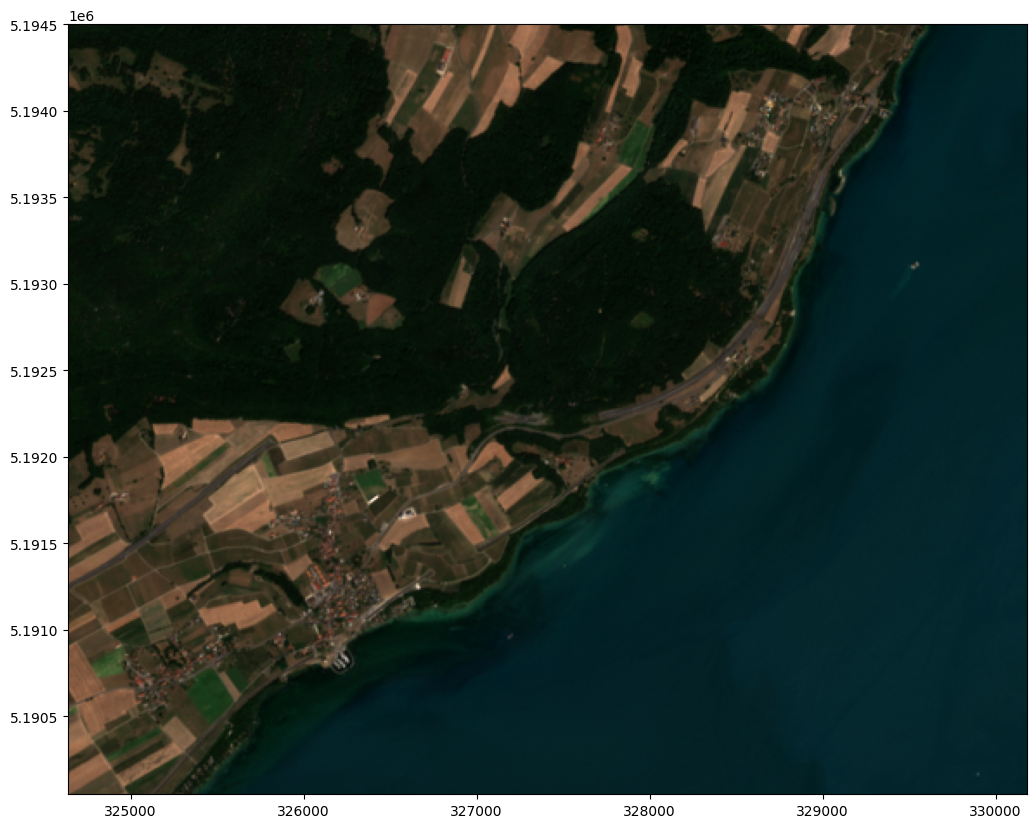

In [31]:
# The following 2 lines "stretch" pixels between the middle 95% of pixel values
p25, p975 = np.percentile(image, (2.5, 97.5))
rgb = exposure.rescale_intensity(image, in_range=(p25, p975))

fig, ax = plt.subplots(figsize=(14,10))
img_extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax.use_sticky_edges = True
ax.imshow(bsq_to_bip(rgb_composite(rgb, 2, 1, 0)), extent=img_extent)

#### Interpreting the histogram

The red, green, and blue histograms correspond to the red, green and blue wavelength bands of the image. The solid black line in the histogram for the near-infrared wavelength band. Each band has a peaked mode in the histogram to the left of the figure, representing low reflectance pixels corresponding to the lake. The higher reflectance pixels to the right of the histogram are more dispered (more or less depending on the band) and correspond to the different land cover types. The near-infrared band has the greatest land-cover dispersion of pixel values.

Text(0.5, 1.0, 'Pixel distributions per color band')

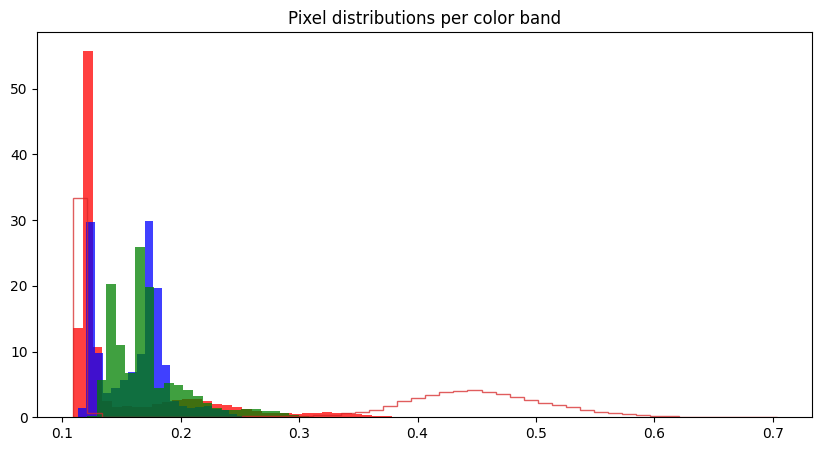

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.hist(image[2].flatten(), 50, density=True, histtype='stepfilled', facecolor='r', ec='r', alpha=0.75)
ax.hist(image[0].flatten(), 50, density=True, histtype='stepfilled', facecolor='b', ec='b', alpha=0.75)
ax.hist(image[1].flatten(), 50, density=True, histtype='stepfilled', facecolor='g', ec='g', alpha=0.75)
ax.hist(image[3].flatten(), 50, density=True, histtype='step', ec='k', alpha=0.75)
ax.set_title("Pixel distributions per color band")

<div class="alert alert-info" role="alert">

### <a id='segmentation'></a>2. Segmentation
[Back to top](#TOC_TOP)

</div>

Segmentation is the first step that distinguishes GEOBIA from pixel-based classification algorithms. Segmentation is the process of grouping pixels that comprise individual image objects and is the most critical part of the GEOBIA process. Segmentation groups similar pixels into clusters of pixels that are identified as single entities.

#### Select algorithm and set parameters

There are many segementation algorithms that can be selected using the [scikit-image](https://scikit-image.org) package, including the Simple Linear Iterative Clustering (SLIC), Felzenszwalb, Watershed and Quickshift algorithms. It the tutorial materials below, we will use the Quickshift algorithm. In the challenge section at the of the tutorial you will have the opportunity to try other algorithms.

Each algorithm has unique parameters that you can alter. Indeed, an analyst's task is to select parameters that partition the image into meaningful segments that can later be classified. Determining optimum parameters is usually done by trial and error and varies from image to image depending on location, illumination, image contrast, etc. The following Quickshift parameters are the ones used for this notebook. (Don't alter these now, you will be able to later.)

In [34]:
quickshift_params = {
    'ratio': 0.5,           # default = 1
    'kernel_size': 2,       # default = 5
    'max_dist': 5,          # default = 10
    'sigma': 0.2,           # default = 0
    'convert2lab': True,    # default = True
    'channel_axis': 2       # for our RGB image this should always be 2
}

#### Segment image

The Quickshift parameters above are passed to the segmentation function below. The function accepts a quickshift model and an RGB color composite of our image. The output (rout) is a Numpy array (i.e., a raster)

In [ ]:
# Quickshift
print(f"Starting segmentation.", end="...")
rout = segmentation(model=quickshift, params=quickshift_params, image=image[:3])
print(f"done.")

Starting segmentation....done.


#### Vectorize raster segments

The raster output from above is passed to the vectorization function in this step. The output of this function (vout) is a GeoPandas dataframe (i.e., a polygon vector) where each polygon represents a cluster of pixels representative of image objects.

In [ ]:
print(f"Starting vectorization.", end="...")
vout = vectorize(image=rout, transform=src.transform, crs=src.crs.to_epsg())
print(f"done.")

Starting vectorization....done.


#### Visualize segmentation

Now we can visualize the segments overlaid on the image. Over the land you are able to see many segments that correspond to field or forest boundaries. Over the lake, you see segments that correspond to different colors of water attributable to different sediment loads. At this point, the segments are only geometries, they do not have any attributes.

<AxesSubplot:>

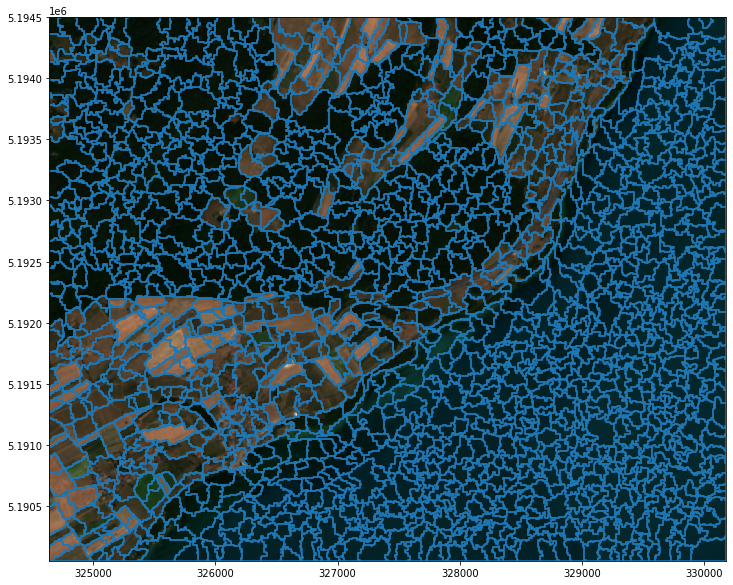

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
img_extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax.use_sticky_edges = True
ax.imshow(bsq_to_bip(rgb_composite(rgb, 2, 1, 0)), extent=img_extent)
vout.boundary.plot(ax=ax)

<div class="alert alert-info" role="alert">

## <a id='attribution'></a>3. Attribution or Feature Extraction
[Back to top](#TOC_TOP)

</div>

Attribution or feature extraction is another step that distinguishes GEOBIA from pixel-based classification algorithms. Each of the image segment geometries needs attributes that can later be classified. The attributes can be anything found at the location of the object geometry, but they generally fall into 3 categories: spectral, shape and texture.

#### Spectral
Spectral attributes are zonal statistics of the original spectral image bands based on the vector segments derived above. For example, the average blue, green, red and near infrared pixels values of each segment are recorded as unique fields in the vector segments file. Any zonal statistic could be used: mean, minimum, maximum, standard deviation, etc.

#### Shape
Geographic objects in a region may have unique shapes, depending on the resolution characteristics of the imagery. For example, tree crowns may be round, homes may be square, lakes may be elongated, etc. Depending on the objects visible in the imagery and the shape of the segments derived from the previous steps, an analyst can choose from a variety of shape parameters. Some of the shape features we extract from the geometries are area, perimeter, major axis length and orientation. Many more are part of the [scikit-image](https://scikit-image.org) package.

#### Texture
Texture describes the pixel-to-pixel variation within an object. Texture is a number calculated at the image object level that indicates whether the object is 'smooth' or 'rough'. One of the most well-known texture measures is the Gray Level Cooccurance Matrix (GLCM), but it is computationally intensive to calculate it.  A simple (and important for this case--fast) method to calculate texture is to apply an edge detection algorithm to the image and then to calculate the mean and standard deviation per segment.

### Spectral attributes

In [ ]:
print(f"Starting add zonal spectral properties.", end="...")
vout = add_zonal_properties(image=image, transform=src.transform,
                            band_names=['blue', 'green', 'red', 'nir'],
                            gdf=vout)
print(f"done.")

Starting add zonal spectral properties....done.


### Shape attributes

In [ ]:
print(f"Starting add shape properties.", end="...")
vout = add_shape_properties(rout, vout, ['area', 'perimeter',
                                        'eccentricity',
                                        'equivalent_diameter',
                                        'major_axis_length',
                                        'minor_axis_length',
                                        'orientation'])
print(f"done.")

Starting add shape properties....done.


### Texture attributes

In [ ]:
print(f"Starting edge detection.", end="...")
edges = sobel_edge_detect(image[3])
print(f"done.")

print(f"Starting add zonal texture properties.", end="...")
vout = add_zonal_properties(image=edges, band_names=['edges'],
                            stats=['mean', 'std'],
                            transform=src.transform, gdf=vout)
print(f"done.")

Starting edge detection....done.
Starting add zonal texture properties....done.


In [ ]:
vout.head()

,geometry,blue_mean,green_mean,red_mean,nir_mean,area,perimeter,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,orientation,edges_mean,edges_std,dn
0,"POLYGON ((327480.000 5194500.000, 327480.000 5...",0.127649,0.145959,0.134366,0.563924,4100.0,340.0,0.945644,7.225152,12.741393,4.143561,1.440833,0.034164,0.024765,1
1,"POLYGON ((325060.000 5194500.000, 325060.000 5...",0.126919,0.144490,0.124561,0.503557,7200.0,440.0,0.657429,9.574615,11.696544,8.813541,1.436558,0.046957,0.025664,6
2,"POLYGON ((326310.000 5194500.000, 326310.000 5...",0.141432,0.165116,0.153372,0.481581,11200.0,520.0,0.761851,11.941643,15.305014,9.913859,1.395996,0.045063,0.024198,7
3,"POLYGON ((328330.000 5194500.000, 328330.000 5...",0.156824,0.184952,0.192864,0.427598,11600.0,500.0,0.642805,12.153016,14.218704,10.891953,1.413716,0.024753,0.017278,3
4,"POLYGON ((328630.000 5194500.000, 328630.000 5...",0.174969,0.207304,0.228889,0.420451,10600.0,620.0,0.818265,11.726460,17.666837,10.155622,1.305706,0.023488,0.014566,4


#### Review of attributes

What we see above is the first 5 segments with their associated attributes. For each segment there are values representative of the mean blue, green, red and near-infrared pixels within the segment. There are 7 shape parameters for each segment, including area, perimeter, eccentricity, equivalent_diameter, major_axis_length, minor_axis_length, and orientation. The two texture measures are the mean and standard deviation of the pixels from a Sobel edge detection filter. These are the attributes that can be used to classify each segment as described in the next section.

<div class="alert alert-info" role="alert">

## <a id='classification'></a>4. Classification
[Back to top](#TOC_TOP)

</div>

It would take many Jupyter notebooks to describe the breadth of classification algorithms available in [scikit-learn](https://scikit-learn.org/stable/index.html). We won't try to cover them all here. We will stick with one that is quite commonly used: the Random Forests algorithm. Random Forests is an ensemble of decision tree algorithms, and decision trees are non-parametric classifiers. Read all about them at [scikit-learn](https://scikit-learn.org/stable/index.html)! For our purposes now regarding GEOBIA, we will use Random Forests to classify the segments by their attributes. But first, there actually is one more attribute to join to our segments: ground reference labels.

#### Ground reference labels

Ground reference points are stored in a GeoPackage in the data folder. There are five classes of points (i.e., five labels) included in the file, specifically forest, grassland-green, grassland-light, lake-deep and lake-sediment, and they are shown below. Below that are displyed the first 5 points in the file. Finally, the points are shown plotted on the image.

In [ ]:
# Open the ground reference training points
ground_data = gpd.read_file("data/training.gpkg", layer='points')

lc_labels = list(ground_data.land_cover_desc.unique())
labels = pd.DataFrame(lc_labels, ground_data.land_cover_id.unique())
labels.columns = ['Land-cover label']
labels

,Land-cover label
4,lake-deep
1,forest
2,grassland-green
3,grassland-light
5,lake-sediment


In [ ]:
ground_data.head()

,land_cover_desc,land_cover_id,geometry
0,lake-deep,4,MULTIPOINT (328993.501 5190963.713)
1,lake-deep,4,MULTIPOINT (328817.429 5191125.726)
2,lake-deep,4,MULTIPOINT (328833.661 5191186.325)
3,lake-deep,4,MULTIPOINT (328736.573 5190934.442)
4,lake-deep,4,MULTIPOINT (328845.564 5190998.035)


<AxesSubplot:>

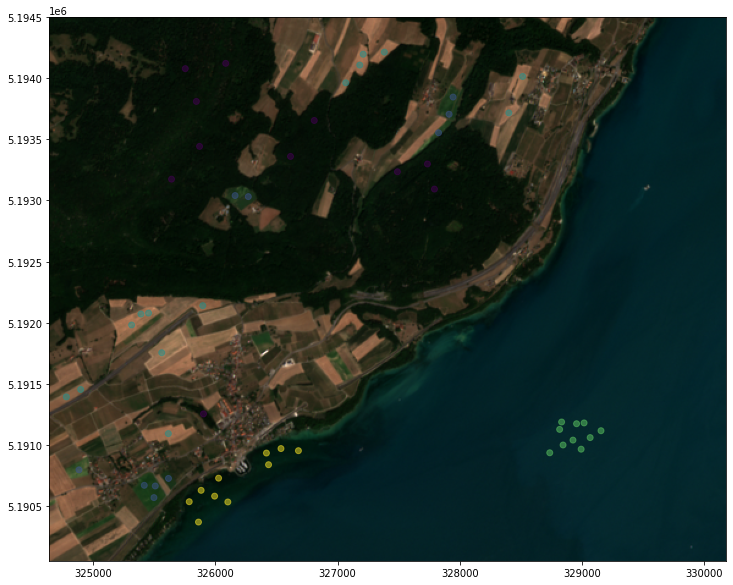

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
img_extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax.use_sticky_edges = True
ax.imshow(bsq_to_bip(rgb_composite(rgb, 2, 1, 0)), extent=img_extent)
ground_data.plot(column='land_cover_id', ax=ax, alpha=0.5)

#### Training Data

This is where we add the ground reference labels to the segments. A spatial join will add the attributes from the labeled points to the segment polygons. You can see in the few records printed below that all attributes, plus the land-cover class labels, are contained in the output table.

In [ ]:
# Do geopandas spatial joins with the ground reference data
labeled = gpd.sjoin(vout, ground_data)
labeled.head()

,geometry,blue_mean,green_mean,red_mean,nir_mean,area,perimeter,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,orientation,edges_mean,edges_std,dn,index_right,land_cover_desc,land_cover_id
116,"POLYGON ((327180.000 5194270.000, 327210.000 5...",0.236790,0.283851,0.357277,0.457144,9100.0,520.0,0.882695,10.764051,16.382787,7.699017,0.246523,0.014692,0.012439,104,31,grassland-light,3
129,"POLYGON ((327400.000 5194310.000, 327440.000 5...",0.227513,0.273107,0.341411,0.464600,18400.0,840.0,0.941872,15.306080,27.136298,9.117012,-0.830723,0.021633,0.019252,74,30,grassland-light,3
153,"POLYGON ((327160.000 5194200.000, 327170.000 5...",0.230699,0.273954,0.342413,0.440230,13500.0,660.0,0.466506,13.110581,14.626315,12.937241,0.494906,0.016768,0.012536,127,32,grassland-light,3
187,"POLYGON ((325710.000 5194200.000, 325720.000 5...",0.125434,0.140760,0.126093,0.443133,65300.0,2080.0,0.862691,28.834449,42.896843,21.694314,1.514657,0.042070,0.025380,136,10,forest,1
206,"POLYGON ((326050.000 5194280.000, 326070.000 5...",0.126310,0.144178,0.127034,0.448572,48800.0,1660.0,0.799696,24.926711,34.401002,20.654534,0.236249,0.040239,0.022241,112,12,forest,1


### Random Forests Classification

#### Training and Testing Sets

It is important to split the labeled segments into training and testing sets. First, we select a subset of all the segemnt attributes as our predictors. Second, we select the labels associated with each segment. The *train_test_split* function randomly assigns two-thirds of the points to the training set and one-third to the test set.

In [ ]:
# Names of columns to be used in the classification
predictors = ["blue_mean", "green_mean", "red_mean", "nir_mean", "area", "perimeter", "major_axis_length", "edges_mean"]

# labeled is the Geopandas dataframe with attributes and labels. X is the selected columns of the data for training.
# y is the selected label column the corresponds to the data in X.
X = labeled[predictors]
y = labeled[["land_cover_id"]]

# This splits X and y into test and training sets. One-third of the training segments are randomly selected for the test set.
# Two-thirds are randomly selected for the training set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

#### Supervised Learning

In [ ]:
clf = rfc(max_depth=5, min_samples_leaf=0.05, random_state=0)

# Fit the algorithm
clf.fit(X_train, np.ravel(y_train))

# Training set prediction
train_prediction = clf.predict(X_train)

# Test set prediction
test_prediction = clf.predict(X_test)

#### Accuracy assessment and visualiation

Below we view the accuracy of the training and test sets. Both accuracy scores are high (training: 97.22%; testing: 89.47%), but there is nearly an 8-point difference between the two. Additional adjustments should likely be made to the training dataset and the configuration of the Random Forests classifier to minimize the difference and reduce the risk of overtraining. For learning GEOBIA now, this level of accuracy is sufficient. Below the overall accuracy scores is a dendrogram with information about the decisions learned from training.

In [ ]:
print(f"Overall accuracy of the training set: {round(accuracy_score(y_train, train_prediction)*100, 2)}%")
print(f"Overall accuracy of the test set: {round(accuracy_score(y_test, test_prediction)*100, 2)}%")

Overall accuracy of the training set: 97.22%
Overall accuracy of the test set: 89.47%


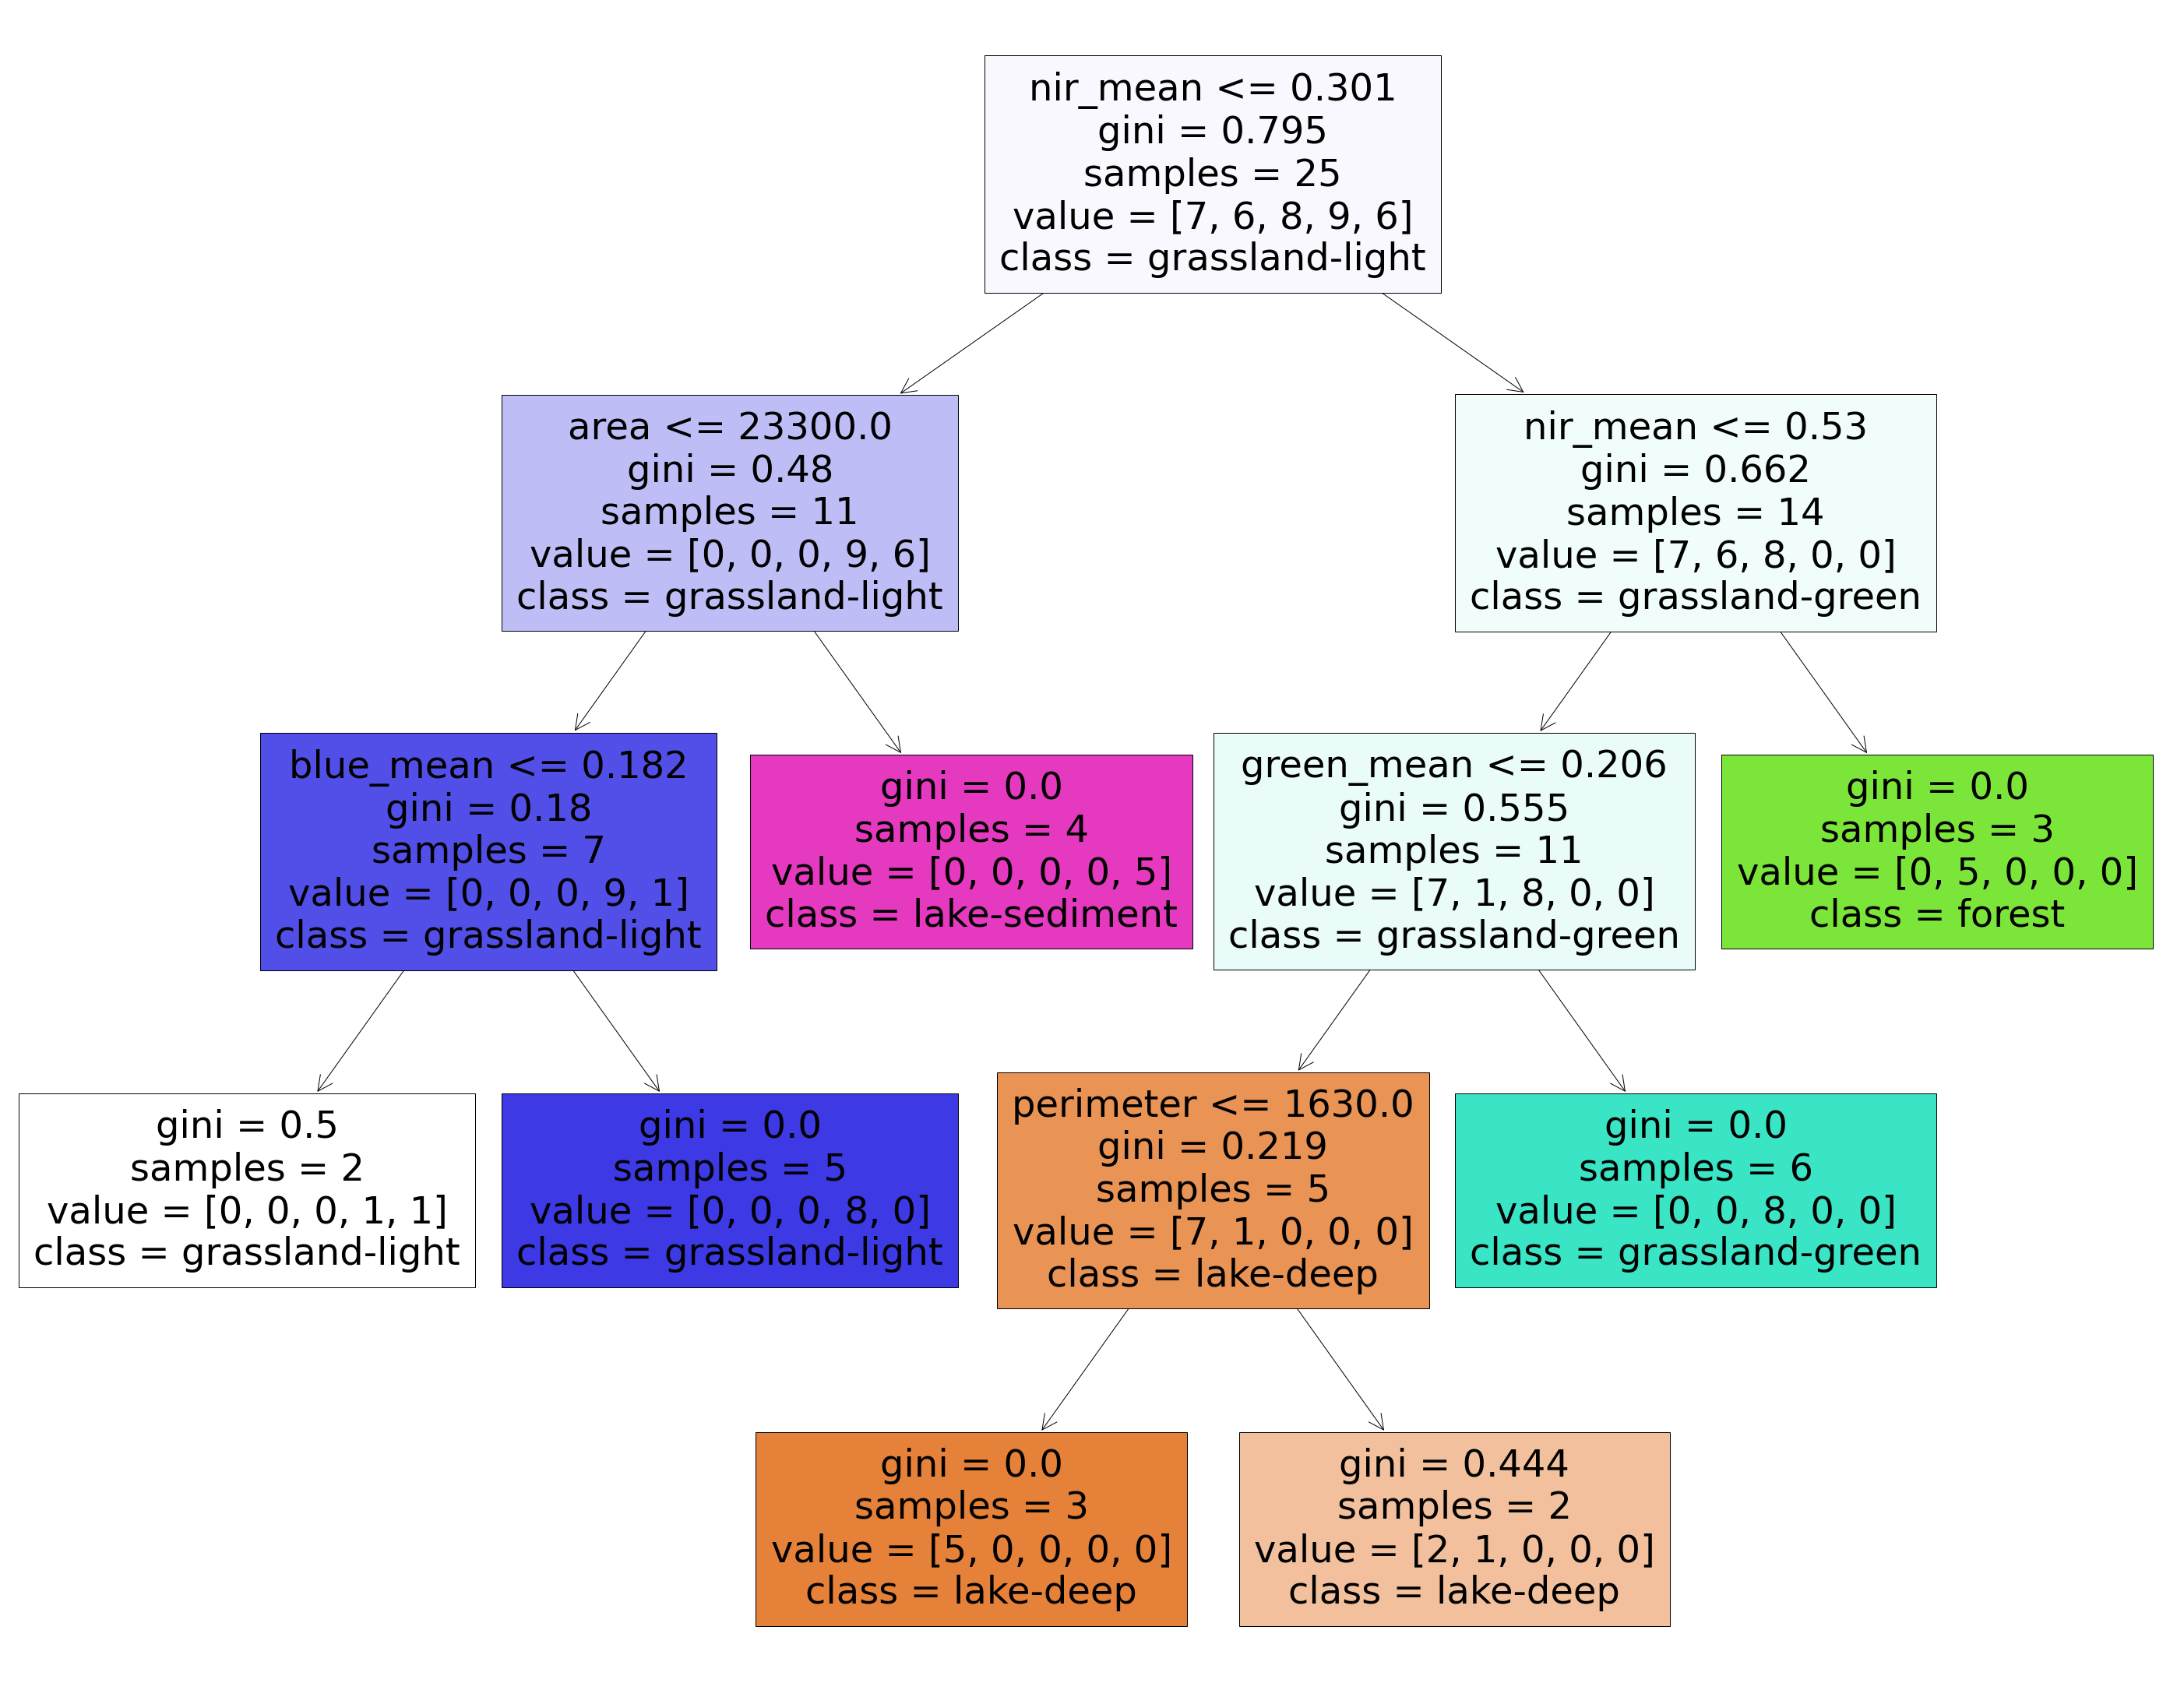

In [ ]:
fig = plt.figure(figsize=(50,40))
annotations = tree.plot_tree(clf.estimators_[0],
                             feature_names=predictors,
                             class_names=lc_labels,
                             filled=True)

#### Apply Learned Classifier To Full Dataset

The final step in the GEOBIA process is to apply the learned Random Forests classifier to the entire dataset. In the cell below, we copy the vector segements and attributes to a new output file and append a new column with the label predictions for each segment. The first five segments are shown below and the full set of segments is mapped below that.

In [ ]:
full_prediction = clf.predict(vout[predictors])
output = vout
output['prediction'] = full_prediction
output.head()

,geometry,blue_mean,green_mean,red_mean,nir_mean,area,perimeter,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,orientation,edges_mean,edges_std,dn,prediction
0,"POLYGON ((327480.000 5194500.000, 327480.000 5...",0.127649,0.145959,0.134366,0.563924,4100.0,340.0,0.945644,7.225152,12.741393,4.143561,1.440833,0.034164,0.024765,1,1
1,"POLYGON ((325060.000 5194500.000, 325060.000 5...",0.126919,0.144490,0.124561,0.503557,7200.0,440.0,0.657429,9.574615,11.696544,8.813541,1.436558,0.046957,0.025664,6,1
2,"POLYGON ((326310.000 5194500.000, 326310.000 5...",0.141432,0.165116,0.153372,0.481581,11200.0,520.0,0.761851,11.941643,15.305014,9.913859,1.395996,0.045063,0.024198,7,2
3,"POLYGON ((328330.000 5194500.000, 328330.000 5...",0.156824,0.184952,0.192864,0.427598,11600.0,500.0,0.642805,12.153016,14.218704,10.891953,1.413716,0.024753,0.017278,3,2
4,"POLYGON ((328630.000 5194500.000, 328630.000 5...",0.174969,0.207304,0.228889,0.420451,10600.0,620.0,0.818265,11.726460,17.666837,10.155622,1.305706,0.023488,0.014566,4,2


<AxesSubplot:>

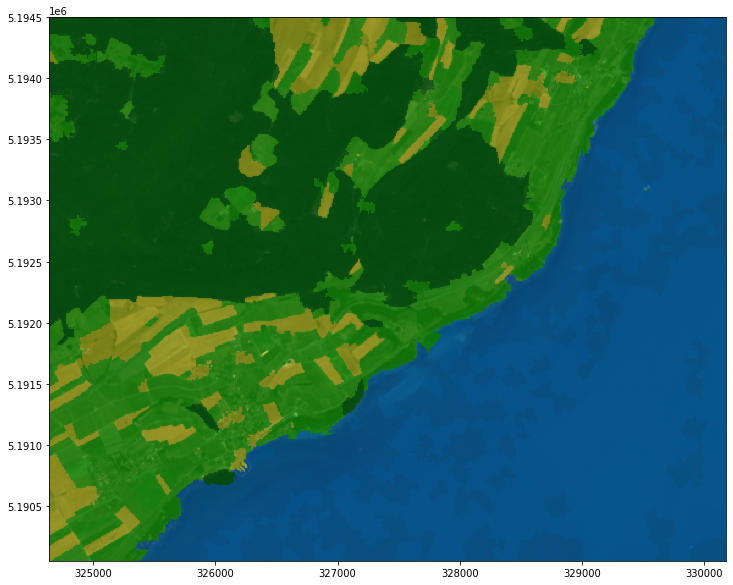

In [ ]:
# This is used to apply a custom color scheme to the figure below
# Dark green = forest, Light green = grassland-green, Yellow = grassland-light, Light blue = lake-deep, Dark blue = lake-sediment
output['color'] = output['prediction'].apply(bin_mapping)

fig, ax = plt.subplots(figsize=(14,10))
img_extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax.use_sticky_edges = True
ax.imshow(bsq_to_bip(rgb_composite(rgb, 2, 1, 0)), extent=img_extent)
output.plot(column='prediction', cmap=lc_cmap, ax=ax, alpha=0.6)

#### Final Interpretation

The vector segments are displayed over the original image with a 40% transparency.
* Dark green is forest.
* Bright green is grassland-green.
* Yellow is grassland-light.
* The lighter blue is lake-deep.
* And the darker blue is lake-sediment.

The test set prediction had an accuracy of approximately 90% and visually it appears that the accuracy for the whole image is similar. Forest and water areas are clearly delineated. Agricultural fields are also clearly delineated. The greenness of a grassland field falls along a spectrum of greenness and there are some fields that could be classified differently. Efforts to make those improvements would be made by adjusting the segmentation output and possibly adjusting the training data. Lastly, the water-land boundary is clearly defined. The differences in water classes are also visible in the color composite.

#### A final comment...

GEOBIA is really an iterative process that isn't apparent in this notebook. Segmentation is usually run many times until good parameters are found. Good parameters will be different for different images and will depend on their spatial, spectral and radiometric resolutions. They will be different for different seasons and places on the Earth. It takes time to find a good set of segmentation parameters. Calculating spectral, shape and texture attributes may not be very iterative, but finding the best combination of them in the classification process can be. Which are the best predictors of your objects of interest? Classification, too, can be very iterative as you refine training data and classification algorithm parameters. Phew! There are lots of moving parts to GEOBIA. BUT, every classification algorithm, properly executed, takes time to get just right. GEOBIA can produce excellent results when you have H-resolution.

<div class="alert alert-danger" role="alert">

### <a id='challenge'></a>Challenge

[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning">

#### Time to explore!

You are encouraged to explore different segmentation algorithms available in the [scikit-image](https://scikit-image.org) package. Below we have prepared parameters for the SLIC and Felzenszwalb algorithms that you can use. Please adjust the parameters and examine the different segments produced.
 <div>

In [ ]:
slic_params = {
    'n_segments': 2500,             # default = 100
    'compactness': 3.5,             # default = 10.0
    'max_num_iter': 20,             # default = 10
    'sigma': 0,                     # default = 0
    'convert2lab': True,            # default = None, but True is highly recommended for RGB images
    'enforce_connectivity': True,   # default = True
    'min_size_factor': 0.5,         # default = 0.5
    'max_size_factor': 3,           # default = 3
    'slic_zero': False,             # default = False (if True, runs zero parameter version of SLIC)
    'channel_axis': 2               # for our RGB image this should always be 2
}

felz_params = {
    'scale': 2.7,      # default = 1
    'sigma': 0.4,      # default = 0.8
    'min_size': 22,    # default = 20
    'channel_axis': 2  # for our RGB image this should always be 2
}

In [ ]:
# SLIC
slic = segmentation(model=slic, params=slic_params, image=image[:3])
slic_vout = vectorize(image=slic, transform=src.transform, crs=src.crs.to_epsg())
# Felzenszwalb
felz = segmentation(model=felzenszwalb, params=felz_params, image=image[:3], sieve_size=30)
felz_vout = vectorize(image=felz, transform=src.transform, crs=src.crs.to_epsg())

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
img_extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax.set_title("SLIC segmentation")
ax.use_sticky_edges = True
ax.imshow(bsq_to_bip(rgb_composite(rgb, 2, 1, 0)), extent=img_extent)
slic_vout.boundary.plot(ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
img_extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax.set_title("Felzenzswalb segmentation")
ax.use_sticky_edges = True
ax.imshow(bsq_to_bip(rgb_composite(rgb, 2, 1, 0)), extent=img_extent)
felz_vout.boundary.plot(ax=ax)